## Overview
The goal of this project is to build a machine learning model for [Zyfra](https://www.zyfra.com/), a company that provides efficient solutions in the mining, oil and gas, chemical and engineering industries. The model should predict the amount of gold recovered from gold ore. It uses 

## Background - The gold recovery process
1. Flotation
- Gold ore mixture is processed in float banks
- Gives us a rougher gold concentrate (with more gold) and rougher tails (leftover material with less valuable metals)
- The stability of the process depends on state of flotation pulp (mixture of solid particles and liquid)

2. Purification
- The rougher gold concentrate then goes through two purification stages
- After the process, we get a final concentrate (more refined with higher gold content) and new tails (leftover material with less valuable metals)

The images below was provided by [TripleTen Data Science bootcamp](https://tripleten.com/data-science/).

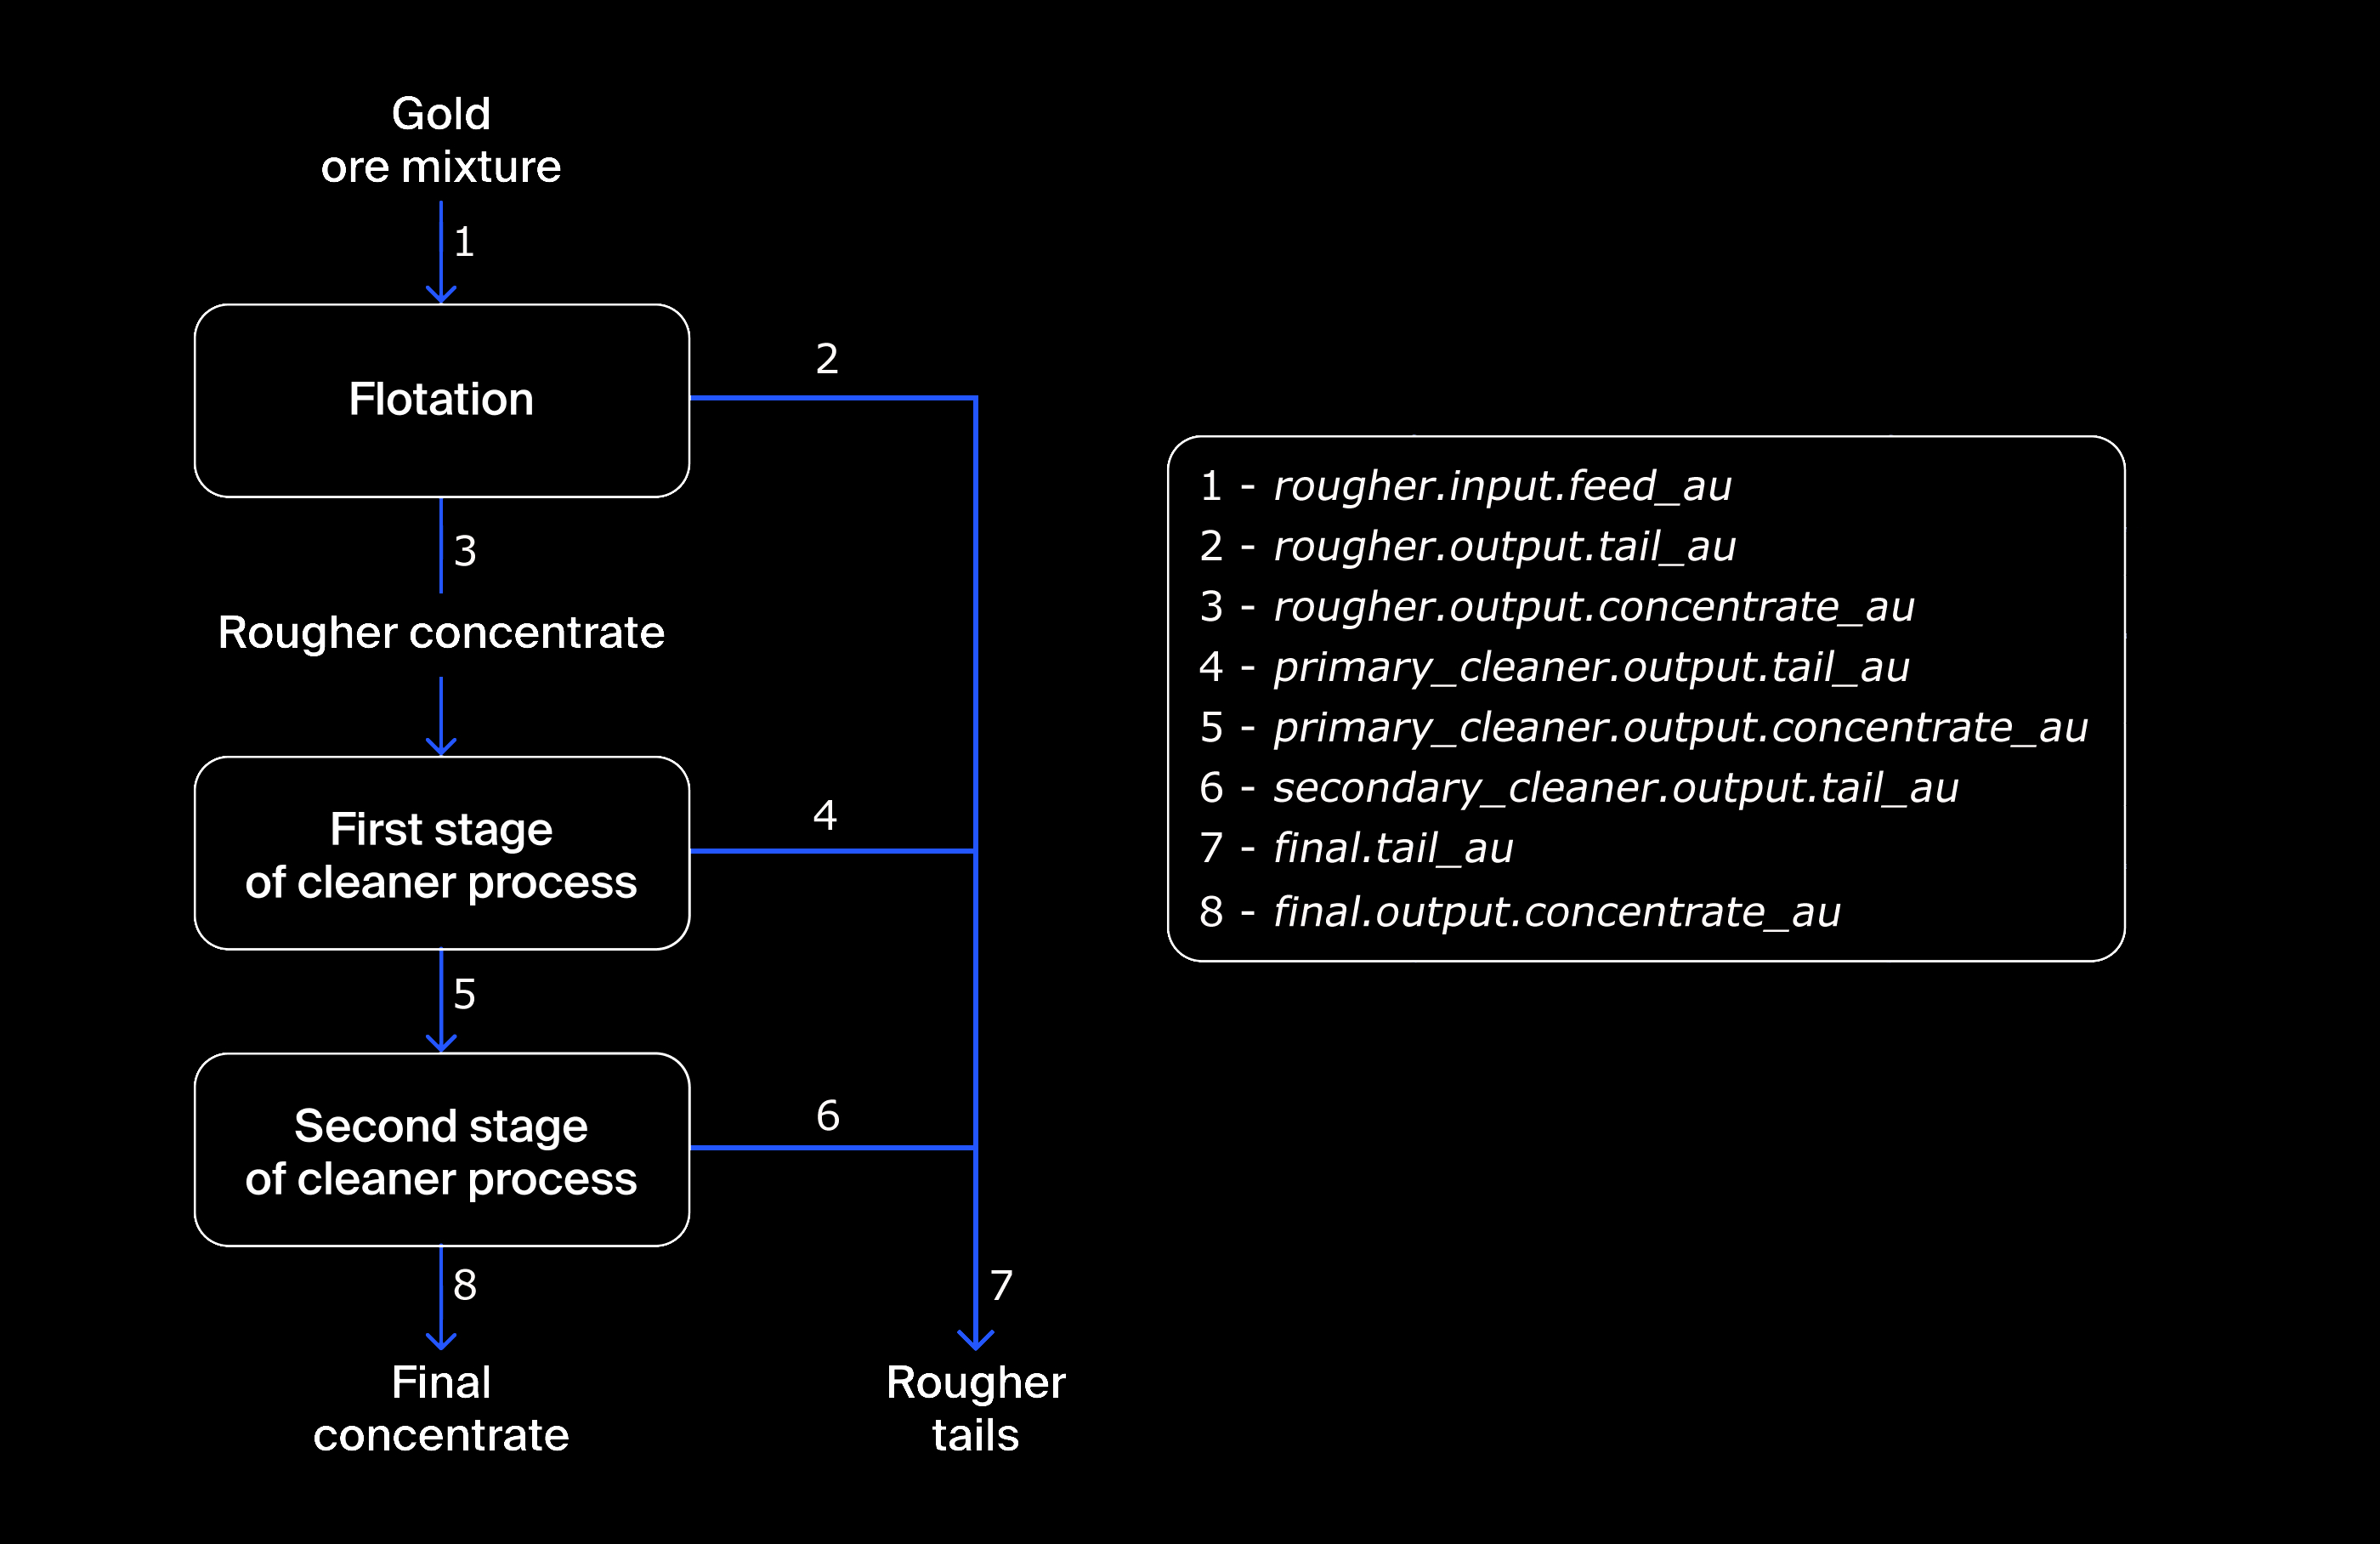

## Understanding the data

In [1]:
# import libraries and data

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.stats import ks_2samp
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

gold_recovery_train = pd.read_csv('gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('gold_recovery_full.csv')

### Check recovery values

Let's use the following formula to calculate recovery manually and compare with the data's rougher.output.recovery values using MAE to check its accuracy. 

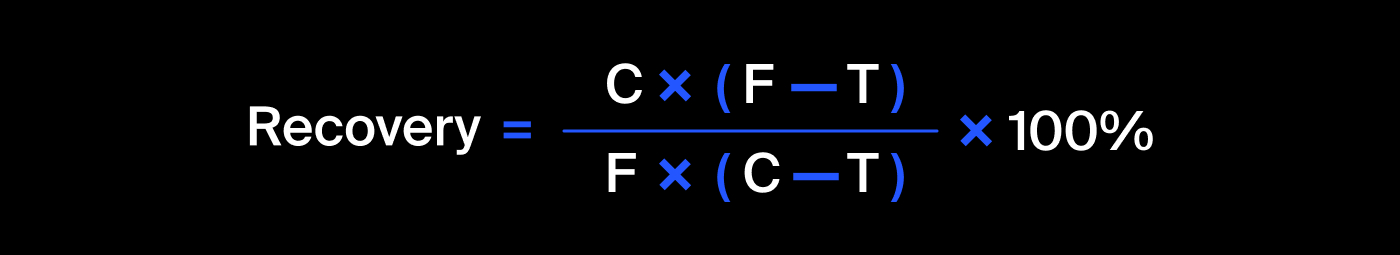

where:

- C — share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
- F — share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)
- T — share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)

In [2]:
# create a df with recovery related data

C = gold_recovery_train['rougher.output.concentrate_au']  # Concentrate
F = gold_recovery_train['rougher.input.feed_au']  # Feed
T = gold_recovery_train['rougher.output.tail_au']  # Tails

recovery_df = gold_recovery_train[['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']].copy()

# calculate recovery and add values to new column
recovery_df.loc[:, 'rougher.output.recovery_calculated'] = ((C * (F - T)) / (F * (C - T))) * 100

# display the resulting df with the calculated recovery
display(recovery_df.head())

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery,rougher.output.recovery_calculated
0,19.793808,6.486150,1.170244,87.107763,87.107763
1,20.050975,6.478583,1.184827,86.843261,86.843261
2,19.737170,6.362222,1.162562,86.842308,86.842308
3,19.320810,6.118189,1.079755,87.226430,87.226430
4,19.216101,5.663707,1.012642,86.688794,86.688794


Now let's use MAE to compare the values in rougher.output.recovery with rougher.output.recovery_calculated.

In [3]:
# Find the MAE between your calculations and the feature values. Provide findings.

recovery_df.dropna(subset=['rougher.output.recovery', 'rougher.output.recovery_calculated'], inplace=True)

mae = mean_absolute_error(recovery_df['rougher.output.recovery'], recovery_df['rougher.output.recovery_calculated'])
print(f'MAE between calculated and original recovery: {mae}')

MAE between calculated and original recovery: 9.303415616264301e-15


The calculated MAE is extremely small and close to zero, indicating that the calculated and actual recovery values are almost identical. Yay!

### Data preprocessing

#### Compare train and test set
Let's analyze the features that exist in train but not test. What are these parameters? What is their type?

In [4]:
# Find columns in the training set that are not in the test set

train_columns = set(gold_recovery_train.columns)
test_columns = set(gold_recovery_test.columns)
features_not_in_test = train_columns - test_columns
features_not_in_test_info = gold_recovery_train[list(features_not_in_test)].dtypes

print("Features not available in the test set:")
print(features_not_in_test_info)

Features not available in the test set:
rougher.output.recovery                               float64
rougher.output.concentrate_ag                         float64
final.output.tail_sol                                 float64
final.output.tail_ag                                  float64
primary_cleaner.output.tail_ag                        float64
rougher.output.tail_au                                float64
secondary_cleaner.output.tail_au                      float64
final.output.concentrate_sol                          float64
rougher.output.concentrate_au                         float64
rougher.calculation.floatbank10_sulfate_to_au_feed    float64
rougher.output.tail_pb                                float64
rougher.output.tail_ag                                float64
primary_cleaner.output.concentrate_pb                 float64
final.output.tail_au                                  float64
primary_cleaner.output.tail_sol                       float64
secondary_cleaner.output.tail_

Since these missing features in test will interfere with our ability to train and test the model, lets remove as many features from the training data that are in only train not test. Let's keep the concentrate related data (and targets), since this is needed in analysis later on.

In [5]:
# concentrate related data
concentrate_columns = gold_recovery_train.filter(like='concentrate')
target_columns = ['rougher.output.recovery', 'final.output.recovery']

# store features not in test and not related to concentrate
remove_from_train = set(features_not_in_test) - set(concentrate_columns) - set(target_columns)
remove_from_train.add('rougher.calculation.sulfate_to_au_concentrate')
remove_from_train

{'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol'}

In [6]:
gold_recovery_train = gold_recovery_train.drop(columns=remove_from_train)
set(gold_recovery_train.columns) - set(gold_recovery_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery'}

Great, now the only difference between train and test set are the concentrate related values that we are using for analysis and the target values.

#### Drop nans

In [7]:
# Drop rows with missing values in training set
gold_recovery_train.dropna(inplace=True)

# Drop rows with missing values in test set
gold_recovery_test.dropna(inplace=True)

print("Does training have any nans? ", gold_recovery_train.isna().sum().any())
print("Does test have any nans?     ", gold_recovery_test.isna().sum().any())

Does training have any nans?  False
Does test have any nans?      False


All nan values have been removed from train and test.

### How does the concentration of metals (Au, Ag, Pb) change depending on the purification stage?

In [8]:
# extract columns relevant to concentration
concentrate_columns = gold_recovery_train.filter(like='concentrate')
concentrate_columns.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au
0,6.055403,9.889648,5.507324,42.192020,8.547551,10.389648,19.529297,34.174427,11.500771,7.101074,28.029297,19.793808
1,6.029369,9.968944,5.257781,42.701629,8.558743,10.497069,19.369147,34.118526,11.615865,7.278807,28.067063,20.050975
2,6.055926,10.213995,5.383759,42.657501,8.603505,10.354494,19.167579,33.969464,11.695753,7.216833,27.454037,19.737170
3,6.047977,9.977019,4.858634,42.689819,7.221879,8.496563,15.978538,28.260743,11.915047,7.175616,27.341277,19.320810
4,6.148599,10.142511,4.939416,42.774141,9.089428,9.986786,19.199864,33.044932,12.411054,7.240205,27.041023,19.216101


,final.output.concentrate_au,primary_cleaner.output.concentrate_au,rougher.output.concentrate_au
0,42.192020,34.174427,19.793808
1,42.701629,34.118526,20.050975
2,42.657501,33.969464,19.737170
3,42.689819,28.260743,19.320810
4,42.774141,33.044932,19.216101


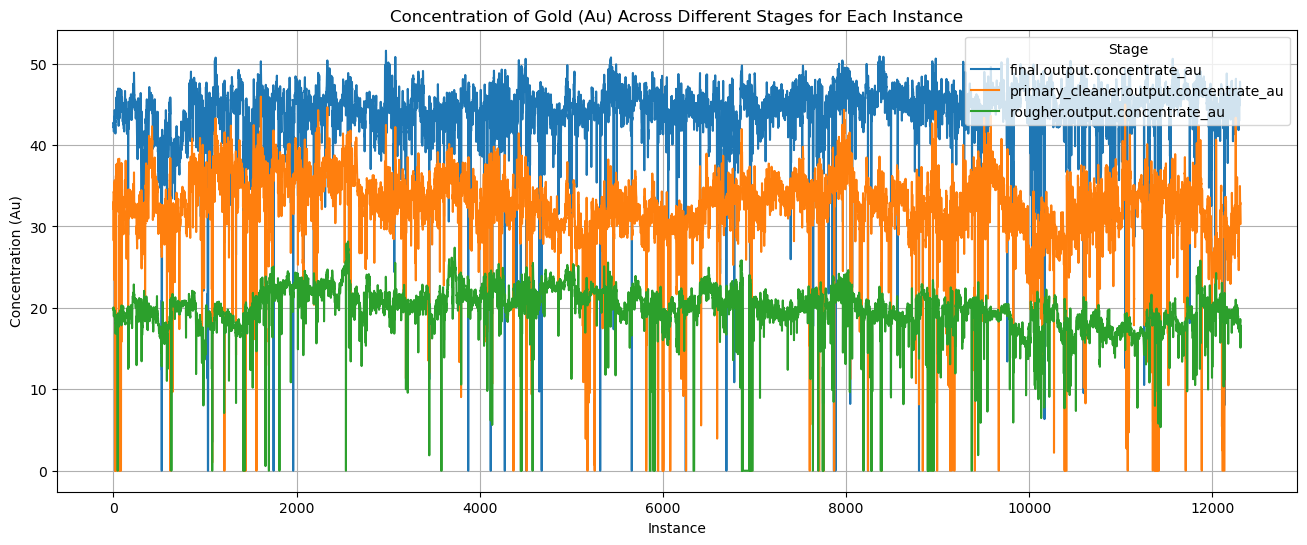

In [9]:
# concentration of au at each stage
concentrate_au = concentrate_columns.filter(like='au')
concentrate_au.reset_index(drop=True, inplace=True)
display(concentrate_au.head())

# visualize
plt.figure(figsize=(16, 6))
for column in concentrate_au.columns:
    plt.plot(concentrate_au.index, concentrate_au[column], label=column)

plt.xlabel('Instance')
plt.ylabel('Concentration (Au)')
plt.title('Concentration of Gold (Au) Across Different Stages for Each Instance')
plt.legend(title='Stage', loc='upper right')
plt.grid(True)
plt.show()

This line plot shows us that the concentration of gold is consistently increasing as it goes through each stage in the gold recovery process as expected. 

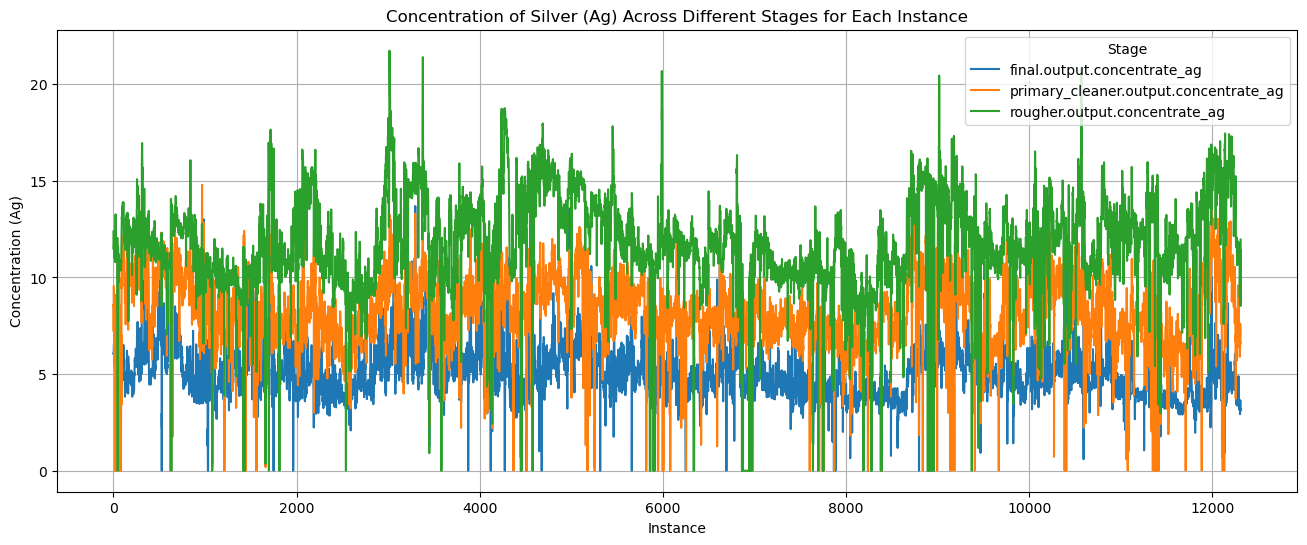

In [10]:
# concentration of ag at each stage
concentrate_ag = concentrate_columns.filter(like='ag')
concentrate_ag.reset_index(drop=True, inplace=True)
concentrate_ag.head()

plt.figure(figsize=(16, 6))

# visualize
for column in concentrate_ag.columns:
    plt.plot(concentrate_ag.index, concentrate_ag[column], label=column)

plt.xlabel('Instance')
plt.ylabel('Concentration (Ag)')
plt.title('Concentration of Silver (Ag) Across Different Stages for Each Instance')
plt.legend(title='Stage', loc='upper right')
plt.grid(True)
plt.show()

Beautiful! As expected, the plot shows us that the concentration of silver is consistently decreasing as it goes through each stage in the gold recovery process.

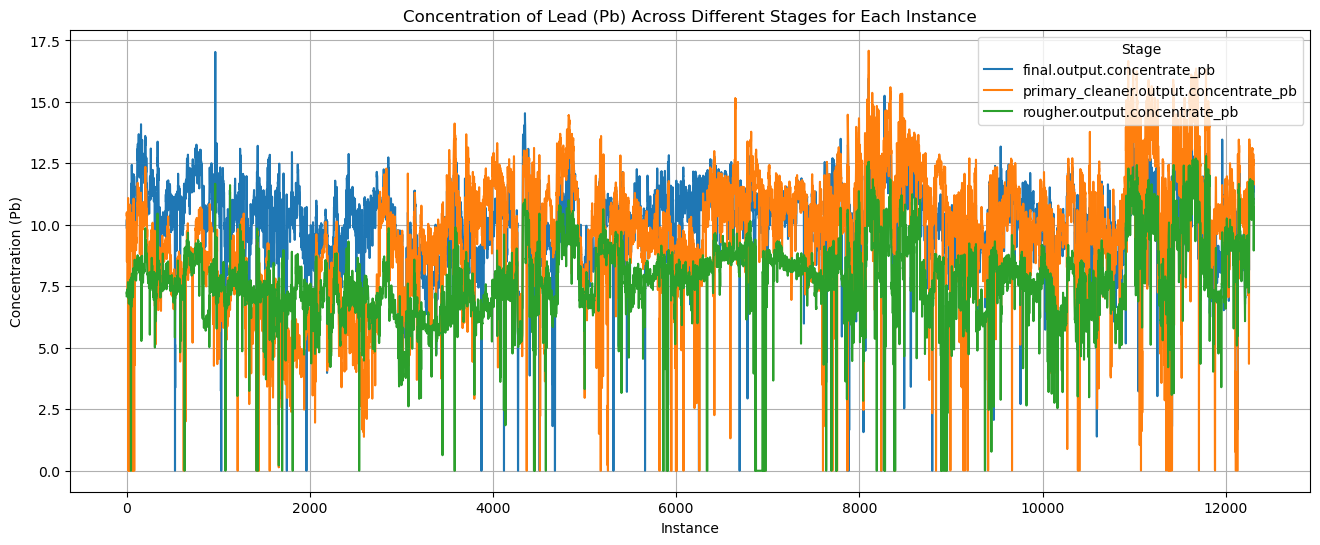

In [11]:
# concentration of pb at each stage
concentrate_pb = concentrate_columns.filter(like='pb')
concentrate_pb.reset_index(drop=True, inplace=True)
concentrate_pb.head()

plt.figure(figsize=(16, 6))

# Plot each stage's concentration using lines
for column in concentrate_pb.columns:
    plt.plot(concentrate_pb.index, concentrate_pb[column], label=column)

plt.xlabel('Instance')
plt.ylabel('Concentration (Pb)')
plt.title('Concentration of Lead (Pb) Across Different Stages for Each Instance')
plt.legend(title='Stage', loc='upper right')
plt.grid(True)
plt.show()

Interesting, it looks like the lead (Pb) concentration is for the most part increasing between the stages. This is unexpected, but shouldn't interfere with our ability to build a model that predicts the amount of gold recovered.

## Addressing outliers in the distribution of total concentration of substances at stages

Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Let's graph the distrubtuion and spot any outliers.

In [12]:
# create a df with the combined values of concentration of different substances for each stage (rougher, primary, final)

summed_df = pd.DataFrame()
summed_df['rougher_total'] =  concentrate_columns[['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au']].sum(axis=1)
summed_df['primary_cleaner_total'] =  concentrate_columns[['primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_au']].sum(axis=1)
summed_df['final_total'] =  concentrate_columns[['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au']].sum(axis=1)
summed_df.head()

,rougher_total,primary_cleaner_total,final_total
0,38.395653,53.111627,58.137072
1,38.945647,53.174338,58.699942
2,38.649756,52.927464,58.927421
3,38.411473,43.979185,58.714815
4,38.867359,52.121146,59.065251


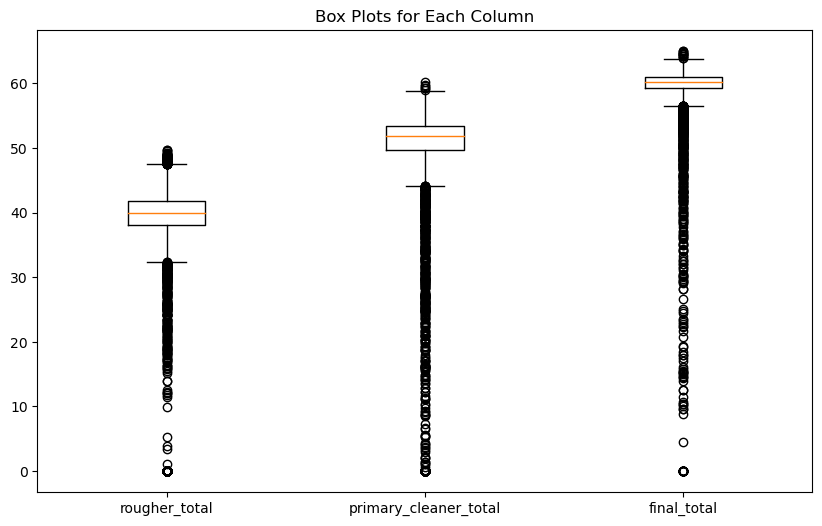

In [13]:
# Create box plots
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(summed_df.values, labels=summed_df.columns)
plt.title('Box Plots for Each Column')
plt.show()

It looks like there are many outliers (points below and above the whiskers) in these three plots. Let's drop these outliers from the dataset.

In [14]:
boxplot_index = 0
rougher_whisker_min = boxplot['whiskers'][2 * boxplot_index].get_ydata()[1]
rougher_whisker_max = boxplot['whiskers'][2 * boxplot_index].get_ydata()[0]

boxplot_index = 1
primary_whisker_min = boxplot['whiskers'][2 * boxplot_index].get_ydata()[1]
primary_whisker_max = boxplot['whiskers'][2 * boxplot_index].get_ydata()[0]

boxplot_index = 2
final_whisker_min = boxplot['whiskers'][2 * boxplot_index].get_ydata()[1]
final_whisker_max = boxplot['whiskers'][2 * boxplot_index].get_ydata()[0]

In [15]:
# drop points below bottom whisker and above top whisker (outliers) for the three plots

summed_df.drop(summed_df[summed_df['rougher_total'] < rougher_whisker_min].index, inplace = True)
summed_df.drop(summed_df[summed_df['rougher_total'] > rougher_whisker_max].index, inplace = True)
summed_df.drop(summed_df[summed_df['primary_cleaner_total'] < primary_whisker_min].index, inplace = True)
summed_df.drop(summed_df[summed_df['primary_cleaner_total'] > primary_whisker_max].index, inplace = True)
summed_df.drop(summed_df[summed_df['final_total'] < final_whisker_min].index, inplace = True)
summed_df.drop(summed_df[summed_df['final_total'] > final_whisker_max].index, inplace = True)

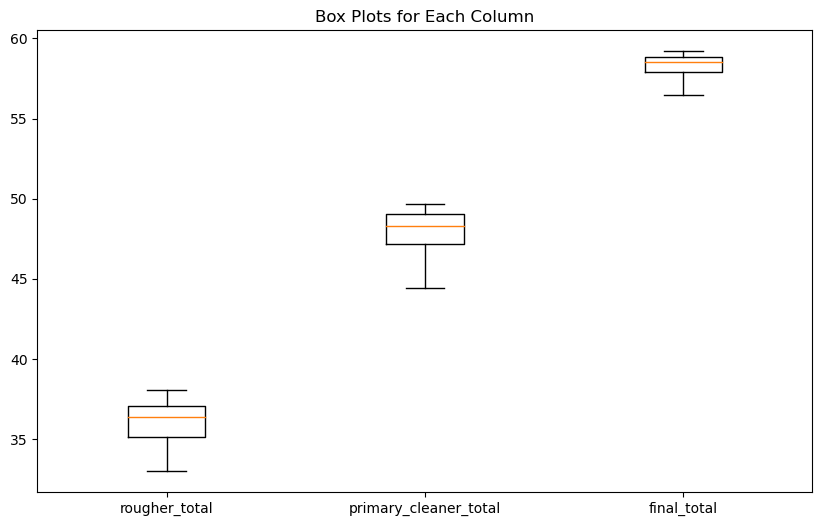

In [16]:
# plot new box plots without outliers
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(summed_df.values, labels=summed_df.columns)
plt.title('Box Plots for Each Column')
plt.show()

After plotting three box plots for the total concentration at each stage, I saw many outliers. I addressed these outliers by removing rows with values below the bottom whisker and above the top whisker. Now onto building the model!

## Building the model

In [17]:
# address remaining features in train not in test (concentrate related)
# the only remaining difference should be the two targets

gold_recovery_train = gold_recovery_train.drop(columns=concentrate_columns)
set(gold_recovery_train)-set(gold_recovery_test)

{'final.output.recovery', 'rougher.output.recovery'}

In [18]:
# define features and targets
features_train = gold_recovery_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train = gold_recovery_train[['rougher.output.recovery', 'final.output.recovery']]

features_train.dropna(inplace=True)
features_train.drop(columns = ['date'], inplace=True)

In [19]:
# since target features are not currently in test set, use gold_recovery_full to help define target_test
gold_recovery_full.dropna(inplace=True)

# identify the rows in gold_recovery_full that are not in gold_recovery_train
rows_not_in_train = gold_recovery_full.index.difference(gold_recovery_train.index)

# create target_test dataframe using the identified rows
target_test = gold_recovery_full.loc[rows_not_in_train, ["rougher.output.recovery", "final.output.recovery"]]

# for features, take values directly from gold_recovery_full that are not in train to ensure that shapes align
features_train_cols = ['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level']

features_test = gold_recovery_full.loc[rows_not_in_train, features_train_cols]

In [20]:
print(features_train.shape)
print(target_train.shape)

print(features_test.shape)
print(target_test.shape)

(12309, 52)
(12309, 2)
(5192, 52)
(5192, 2)


### Writing a function that calculates sMAPE

sMAPE is a metric that measures the percent difference between predicted and actual values. 

In [21]:
def calculate_smape(y_true, y_pred):
    """
    Calculate the sMAPE (symmetric Mean Absolute Percentage Error).

    Parameters:
    - y_true: List or array of true values.
    - y_pred: List or array of predicted values.

    Returns:
    - sMAPE value.
    """
    N = len(y_true)
    
    # Avoid division by zero
    denominator = (abs(y_true) + abs(y_pred)) / 2
    diff = abs(y_true - y_pred) / denominator
    
    # Replace NaN values with 0 (when both true and predicted values are 0)
    diff = diff.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    smape = (1/N) * np.sum(diff) * 100
    
    return smape

### Initialize models, predict with cross validation, and calculate sMAPE

In [22]:
# Model 1: Random Forest
rf_model = RandomForestRegressor()
rf_cv_predictions = cross_val_predict(rf_model, features_train, target_train, cv=5)
rf_smape = calculate_smape(target_train, rf_cv_predictions)

# Model 2: Linear Regression
lr_model = LinearRegression()
lr_cv_predictions = cross_val_predict(lr_model, features_train, target_train, cv=5)
lr_smape = calculate_smape(target_train, lr_cv_predictions)

In [23]:
# Find the model with the lowest sMAPE
print('Random Forest sMAPE:')
print(rf_smape)
print('\nLinear Regression sMAPE:')
print(lr_smape)

Random Forest sMAPE:
rougher.output.recovery    12.514766
final.output.recovery       9.697081
dtype: float64

Linear Regression sMAPE:
rougher.output.recovery    10.611963
final.output.recovery      10.566242
dtype: float64


Based on these results, for rougher.output.recovery, the Linear Regression model outperforms the Random Forest model. For final.output.recovery, the Random Forest model outperforms the Linear Regression model.

In [24]:
# Model 1: Random Forest for final.output.recovery
rf_final_model = RandomForestRegressor()
rf_final_model.fit(features_train, target_train['final.output.recovery'])

# Make predictions on the test set for final.output.recovery
rf_final_predictions = rf_final_model.predict(features_test)

# Model 2: Linear Regression for rougher.output.recovery
lr_rougher_model = LinearRegression()
lr_rougher_model.fit(features_train, target_train['rougher.output.recovery'])

# Make predictions on the test set for rougher.output.recovery
lr_rougher_predictions = lr_rougher_model.predict(features_test)

In [25]:
# Display the sMAPE for each target
smape_final = calculate_smape(target_test['final.output.recovery'], rf_final_predictions)
smape_rougher = calculate_smape(target_test['rougher.output.recovery'], lr_rougher_predictions)

print("sMAPE for final.output.recovery (Random Forest):", smape_final)
print("sMAPE for rougher.output.recovery (Linear Regression):", smape_rougher)

sMAPE for final.output.recovery (Random Forest): 4.311055328943731
sMAPE for rougher.output.recovery (Linear Regression): 8.232102104550153


## Conclusion

**Preparing the data**

1. I calculated recovery and compared it to rougher.output.recovery, finding that the MAE between calculated and original recovery was 9.303415616264301e-15. Since this is extremely small and close to zero, the calculated and actual recovery values were found to be almost identical.
<br>

2. I removed all features that were in training and not test, except for those related to concentrate (since this was used for analysis later) and target values (rougher.output.recovery and final.output.recovery). I removed concentrate values after analysis to build the model. I also dropped the date column since this info provided no value and removed nans from train and test.

**Analyzing the data**

1. I used line plots to compare concentrations of metals (Au, Ag, Pb) across the purification stages.
<br>    a) Concentration of gold was consistently increasing as it went through each stage in the process, as expected.
<br>    b) Concentration of silver wass consistently decreasing as expected.
<br>    c) Lead (Pb) concentration was surprisingly increasing through the stages. However, since it wouldn't interfere with my     ability to build the model, I didn't change the data.
<br>

2. I analyzed the total concentrations of all substances at various stages, including raw feed, rougher concentrate, and final concentrate. The box plots revealed numerous outliers, both below and above the whiskers. To address this issue, I removed data points that fell below the bottom whisker and above the top whisker across all three plots.

**Building the model**

1. I started by removing the remaining features from train that were not in test (concentrate related).
<br>
2. I used gold_recovery_full to get features_test and target_test values, while ensuring that shapes aligned.
<br>
3. I defined a function to calculate sMAPE.
<br>
4. Using the results of cross validation and sMAPE calculation comparing Linear Regression and Random Forest models, I found that for rougher.output.recovery, the Linear Regression model outperformed the Random Forest model. For final.output.recovery, the Random Forest model outperforms the Linear Regression model.
- Random Forrest sMAPE:
    - rougher.output.recovery    12.514766
    - final.output.recovery       9.697081
- Linear Regression sMAPE:
    - rougher.output.recovery    10.611963
    - final.output.recovery      10.566242


5. So, I trained a Random Forest model to predict final.output.recovery and a Linear Regression model to predict rougher.output.recovery. The resulting sMAPE calculations comparing predictions with target test values were the following,
- sMAPE for final.output.recovery (Random Forest): 4.311055328943731
- sMAPE for rougher.output.recovery (Linear Regression): 8.232102104550153

Overall, the Random Forest model did a better job of predicting final.output.recovery than Linear Regression did of predicting rougher.output.recovery. This prototype machine learning model that predicts the amount of gold recovered (rougher.output.recovery and final.output.recovery) is ready to share with Zyfra!